In [1]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from dsa_analysis import load_config, visualize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
import main
from main import RNNLayer
import ast

%load_ext autoreload
%autoreload 2

### Load config

In [2]:
config = load_config("../config.yaml")
taskset = "PDM"

In [3]:
def parse_model_info(model_name):
    model_name = model_name.replace('.pth', '')
    model_name = model_name.split('_')
    model_type = model_name[0] + '_' + model_name[1]
    if len(model_name) == 8:    
        activation = model_name[2] + '_' + model_name[3]
        hidden_size = int(model_name[4])
        learning_rate = float(model_name[5])
        batch_size = int(model_name[6])
    else:
        activation = model_name[2]
        hidden_size = int(model_name[3])
        learning_rate = float(model_name[4])
        batch_size = int(model_name[5])
    return model_type, activation, hidden_size, learning_rate, batch_size

parse_model_info('leaky_gru_leaky_relu_128_0.001_128_train.pth')



('leaky_gru', 'leaky_relu', 128, 0.001, 128)

In [4]:
def get_dynamics_rnn(rnn_type, activation, hidden_size, lr, model, group,device, n_components=3):
    # Load configuration and set hyperparameters
    config = load_config("../config.yaml")
    ruleset = config[taskset]["rules_analysis"][-1]
    all_rules = config[taskset]["rules_analysis"]

    hp = {
        "rnn_type": rnn_type,
        "activation": activation,
        "n_rnn": hidden_size,
        "learning_rate": lr,
        "l2_h": 0.00001,
        "l2_weight": 0.00001,
        "mode": "test",
    }
    hp, _, _ = main.set_hyperparameters(
        model_dir="debug", hp=hp, ruleset=all_rules, rule_trains=ruleset
    )
    run_model = main.load_model(
        f"../models/{taskset}/{group}/{model}",
        hp,
        RNNLayer,
        device=device,
    )
    h = main.representation(run_model, all_rules)
    h_trans, explained_variance = main.compute_pca(h, n_components=n_components)
    if taskset == "PDM":
        tensor_on_cpu = h_trans[
            ("AntiPerceptualDecisionMakingDelayResponseT", "stimulus")
        ].cpu()
    else:
        tensor_on_cpu = h_trans[("AntiGoNogoDelayResponseT", "stimulus")].cpu()
    return tensor_on_cpu.detach().numpy(), explained_variance

### Get dynamics to plot

In [5]:
model = "leaky_rnn_leaky_relu_256_0.001_128_train.pth"

#### Pretrain unfrozen

In [6]:
group = "master"
model_type, activation, hidden_size, lr, batch_size = parse_model_info(model)
curve, explained_variance = get_dynamics_rnn(
    model_type, activation, hidden_size, lr, model, group, "cpu", n_components=3 
)

In [7]:
explained_variance

0.9647996238197878

#### Visualize the curves

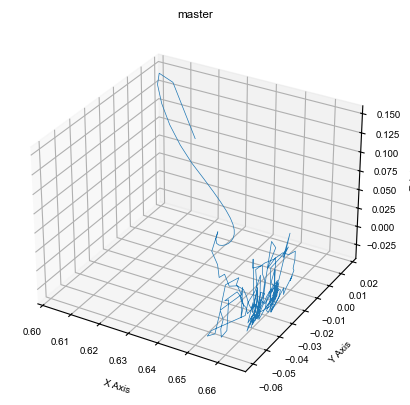

In [8]:
visualize([curve[:,50,:]],title=group)

### Get dissimilarities

#### Computation dynamics

In [10]:
# load data
path = f"../data/dissimilarities/{taskset}/"
files = os.listdir(path)
data = []
for file in files:
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(path, file))
        data.append(df)
data = pd.concat(data)

In [11]:
data

,model1,model2,group1,group2,cka,procrustes,dsa,accuracy_group1,accuracy_group2,explained_variance_group1,explained_variance_group2
0,leaky_gru_softplus_256_0.0001_128_train,leaky_gru_softplus_256_0.0001_128_train,pretrained_basic_anti_frozen,basic,0.578329,0.546469,0.408879,0.782267,0.771040,0.999612,0.999181
1,leaky_gru_relu_256_0.0001_256_train,leaky_gru_relu_256_0.0001_256_train,pretrained_basic_anti_frozen,basic,0.788694,0.669242,0.346587,0.823181,0.770902,0.993220,0.994621
2,leaky_gru_tanh_128_0.0001_128_train,leaky_gru_tanh_128_0.0001_128_train,pretrained_basic_anti_frozen,basic,0.550280,0.521353,0.348586,0.825395,0.858344,0.998560,0.996914
3,leaky_rnn_relu_256_0.001_128_train,leaky_rnn_relu_256_0.001_128_train,pretrained_basic_anti_frozen,basic,0.918232,0.794028,0.350941,0.988514,0.850398,0.988548,0.996530
4,leaky_gru_leaky_relu_256_0.0001_128_train,leaky_gru_leaky_relu_256_0.0001_128_train,pretrained_basic_anti_frozen,basic,0.793583,0.648280,0.380286,0.891796,0.877644,0.995069,0.994806
...,...,...,...,...,...,...,...,...,...,...,...
58,leaky_rnn_relu_256_0.0001_128_train,leaky_rnn_relu_256_0.0001_128_train,pretrain_unfrozen,master,0.838513,0.712531,0.289830,0.988432,0.938347,0.983467,0.995662
59,leaky_gru_softplus_256_0.0001_256_train,leaky_gru_softplus_256_0.0001_256_train,pretrain_unfrozen,master,0.875209,0.703978,0.330205,0.908661,0.850248,0.998901,0.993991
60,leaky_rnn_leaky_relu_256_0.001_256_train,leaky_rnn_leaky_relu_256_0.001_256_train,pretrain_unfrozen,master,0.914280,0.773409,0.294958,0.926988,0.989935,0.968661,0.999305
61,leaky_gru_softplus_128_0.001_256_train,leaky_gru_softplus_128_0.001_256_train,pretrain_unfrozen,master,0.936660,0.762011,0.330259,0.985221,0.907683,0.999729,0.994228


In [12]:
# Define groups and threshold
groups_to_check = ["master", "basic", "pretrain_unfrozen","pretrained_basic_anti_unfrozen"]
accuracy_threshold = 0.9

# Filter the DataFrame
data = data[
    ~(
        (
            (data["group1"].isin(groups_to_check))
            & (data["accuracy_group1"] < accuracy_threshold)
        )
        | (
            (data["group2"].isin(groups_to_check))
            & (data["accuracy_group2"] < accuracy_threshold)
        )
    )
]
data

,model1,model2,group1,group2,cka,procrustes,dsa,accuracy_group1,accuracy_group2,explained_variance_group1,explained_variance_group2
6,leaky_rnn_tanh_256_0.001_128_train,leaky_rnn_tanh_256_0.001_128_train,pretrained_basic_anti_frozen,basic,0.983505,0.886990,0.407472,0.982900,0.985940,0.997083,0.995612
8,leaky_gru_leaky_relu_128_0.0001_128_train,leaky_gru_leaky_relu_128_0.0001_128_train,pretrained_basic_anti_frozen,basic,0.509736,0.443570,0.485884,0.724566,0.904665,0.998404,0.997585
11,leaky_gru_leaky_relu_128_0.001_128_train,leaky_gru_leaky_relu_128_0.001_128_train,pretrained_basic_anti_frozen,basic,0.893863,0.782347,0.359585,0.979268,0.945129,0.994464,0.995852
13,leaky_rnn_tanh_128_0.001_256_train,leaky_rnn_tanh_128_0.001_256_train,pretrained_basic_anti_frozen,basic,0.917958,0.799074,0.381533,0.986703,0.904566,0.999251,0.999565
16,leaky_rnn_relu_256_0.001_256_train,leaky_rnn_relu_256_0.001_256_train,pretrained_basic_anti_frozen,basic,0.838849,0.702649,0.369015,0.988399,0.938064,0.989244,0.991451
...,...,...,...,...,...,...,...,...,...,...,...
57,leaky_gru_relu_256_0.001_128_train,leaky_gru_relu_256_0.001_128_train,pretrain_unfrozen,master,0.530006,0.543273,0.263649,0.985221,0.978064,0.989244,0.999677
58,leaky_rnn_relu_256_0.0001_128_train,leaky_rnn_relu_256_0.0001_128_train,pretrain_unfrozen,master,0.838513,0.712531,0.289830,0.988432,0.938347,0.983467,0.995662
60,leaky_rnn_leaky_relu_256_0.001_256_train,leaky_rnn_leaky_relu_256_0.001_256_train,pretrain_unfrozen,master,0.914280,0.773409,0.294958,0.926988,0.989935,0.968661,0.999305
61,leaky_gru_softplus_128_0.001_256_train,leaky_gru_softplus_128_0.001_256_train,pretrain_unfrozen,master,0.936660,0.762011,0.330259,0.985221,0.907683,0.999729,0.994228


In [13]:
# Create a new DataFrame with swapped values
df_swapped = data.rename(
    columns={
        "model1": "model2",
        "model2": "model1",
        "group1": "group2",
        "group2": "group1",
    }
)

# Concatenate the original DataFrame with the swapped DataFrame
data = pd.concat([data, df_swapped], ignore_index=True)

data_models_averaged = (
    data.groupby(["group1", "group2"])[["cka", "procrustes", "dsa"]]
    .agg(["mean", "std"])
    .reset_index()
)

# Flatten the multi-index columns
data_models_averaged.columns = [
    "_".join(col).strip() if isinstance(col, tuple) else col
    for col in data_models_averaged.columns
]

In [14]:
# Pivot the data for heatmap
mean_df = data_models_averaged.pivot(
    index="group1_",
    columns="group2_",
    values=["cka_mean", "procrustes_mean", "dsa_mean"],
)
std_df = data_models_averaged.pivot(
    index="group1_", columns="group2_", values=["cka_std", "procrustes_std", "dsa_std"]
)

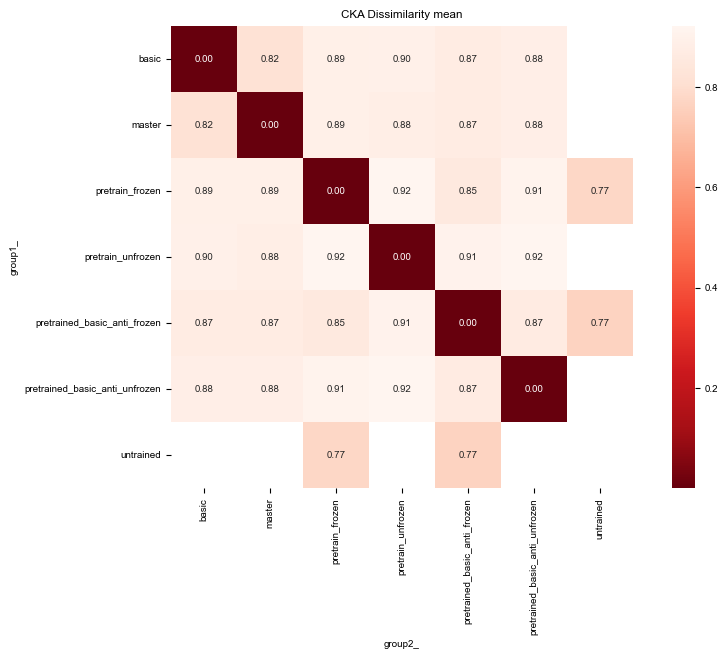

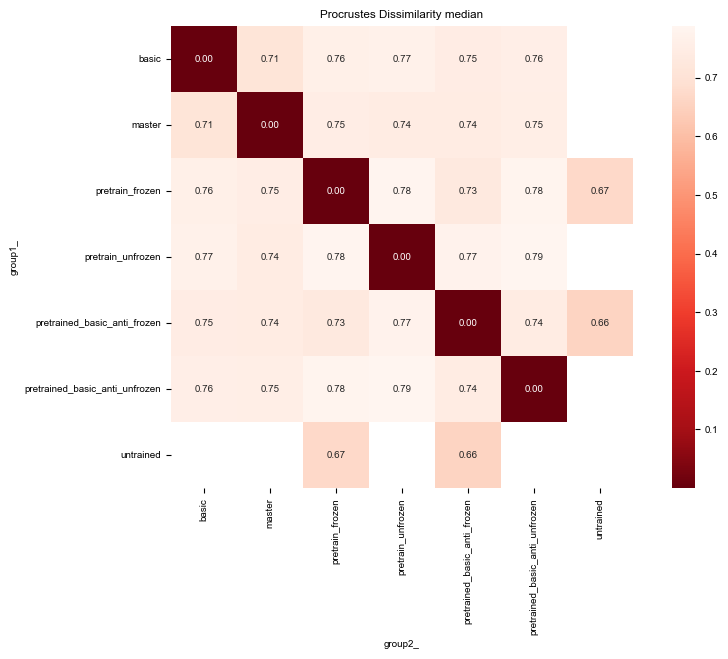

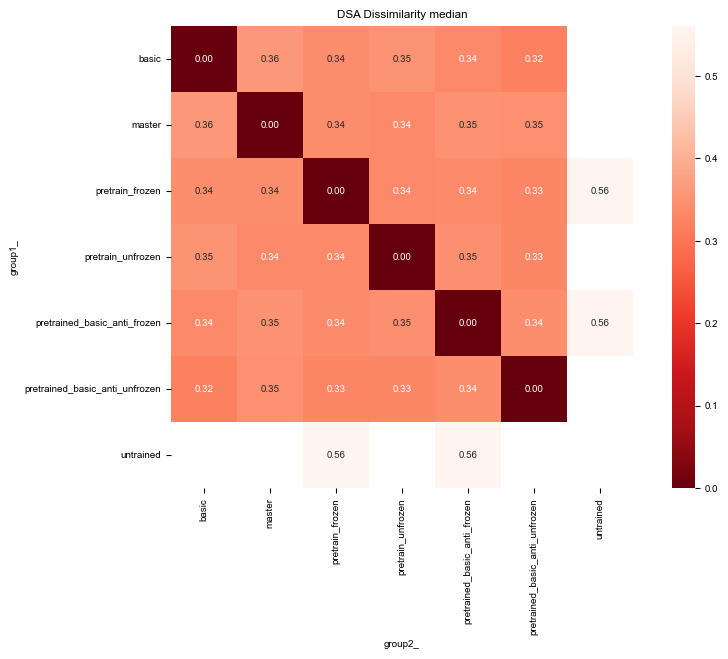

In [15]:
# Function to plot heatmap with a single color
def plot_heatmap(data, title, cmap="Reds_r"):
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        data,
        annot=True,
        cmap=cmap,
        cbar=True,
        square=True,
        fmt=".2f",
    )
    plt.title(title)
    plt.show()


# Plot mean heatmaps with single color
plot_heatmap(mean_df["cka_mean"], "CKA Dissimilarity mean", cmap="Reds_r")
plot_heatmap(
    mean_df["procrustes_mean"], "Procrustes Dissimilarity median", cmap="Reds_r"
)
plot_heatmap(mean_df["dsa_mean"], "DSA Dissimilarity median", cmap="Reds_r")

#### Learning dynamics

For now, only analysis for pretrain_frozen against pretrain_unfrozen

In [9]:
# take all the folder names under data/dissimilarities_over_learning/{taskset}
groups_training = os.listdir(f"../data/dissimilarities_over_learning/{taskset}")

dissimilarities_groups = {group: None for group in groups_training}
for group_training in groups_training: 
    path = f"../data/dissimilarities_over_learning/{taskset}/{group_training}"
    measures = ["cka", "dsa", "procrustes", "accuracy_1", "accuracy_2"]
    sampling = [0, 25, 50, 75, 100]
    dissimilarities = {measure: [] for measure in measures}

    for measure in measures:
        path_measure = os.path.join(path, measure)
        files = os.listdir(path_measure)
        for file in files:
            file_path = os.path.join(path_measure, file)
            if file_path.endswith(".npz"):
                with np.load(file_path) as data:
                    dissimilarities[measure].append(data["arr_0"])
    dissimilarities_interpolated = {
        measure: {group: [] for group in range(len(sampling) - 1)} for measure in measures
    }
    for measure in measures:
        for dissimilarity in dissimilarities[measure]:
            if dissimilarity.shape[0] > 4:
                for i in range(len(sampling) - 1):
                    index_start = int(sampling[i] / 100 * (dissimilarity.shape[0]))
                    index_end = int(sampling[i + 1] / 100 * (dissimilarity.shape[0]))
                    dissimilarities_interpolated[measure][i].append(
                        np.median(dissimilarity[index_start:index_end])
                    )
    for measure in measures:
        for group in range(len(sampling) - 1):
            dissimilarities_interpolated[measure][group] = np.mean(
                dissimilarities_interpolated[measure][group]
            )
    dissimilarities_groups[group_training] = dissimilarities_interpolated

NotADirectoryError: [Errno 20] Not a directory: '../data/dissimilarities_over_learning/PDM/.DS_Store/cka'

In [10]:
for group_training in groups_training:
    dissimilarities_interpolated = dissimilarities_groups[group_training]
    # X-axis values
    x_values = [25, 50, 75, 100]

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot each key with a different color
    for key, values in dissimilarities_interpolated.items():
        plt.plot(x_values, list(values.values()), marker="o", label=key)

    # Adding labels and title
    plt.xlabel("Percentage of Training")
    plt.ylabel("Values")
    plt.title("Dissimilarity over training for {}".format(group_training))
    plt.legend()

    # Display the plot
    plt.grid(True)
    plt.show()

AttributeError: 'NoneType' object has no attribute 'items'

<Figure size 1000x600 with 0 Axes>

### Dissimilarity within group 

In [26]:
path = f"../data/dissimilarities_within_learning/{taskset}/pretrain_frozen"
measures = ['cka','dsa','procrustes']
dissimilarities = {measure:[] for measure in measures}


for measure in measures:
    path_measure = os.path.join(path, measure)
    files = os.listdir(path_measure)
    for file in files:
        file_path = os.path.join(path_measure, file)
        if file_path.endswith(".npz"):
            with np.load(file_path) as data:
                dissimilarities[measure].append(data["arr_0"])
# Function to check if any non-diagonal element is less than the threshold
def has_small_non_diagonal_elements(arr, threshold=1e-10):
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if i != j and arr[i, j] < threshold:
                return True
    return False
for (
    measure,
    value,
) in dissimilarities.items():  # Stack the arrays along a new axis (axis 0)
    dissimilarities[measure] = [
        arr for arr in value if not has_small_non_diagonal_elements(arr)
    ]
for (
    measure,
    value,
) in dissimilarities.items():  # Stack the arrays along a new axis (axis 0)
    dissimilarities[measure] = np.median(np.stack(value, axis=0), axis=0)

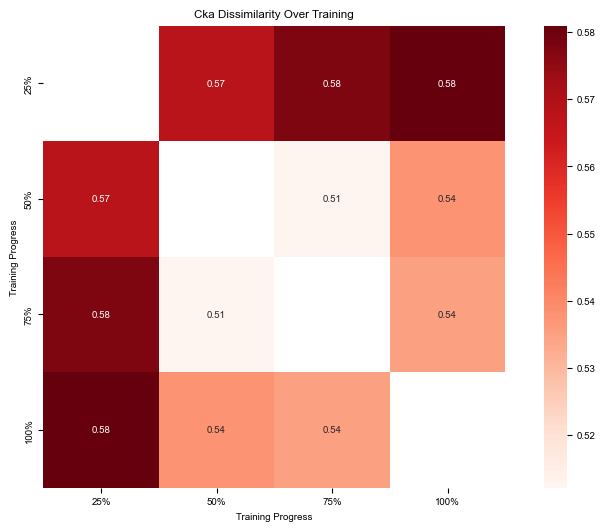

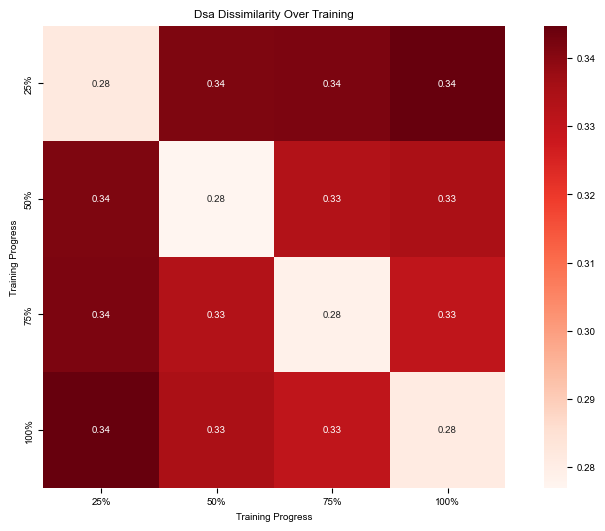

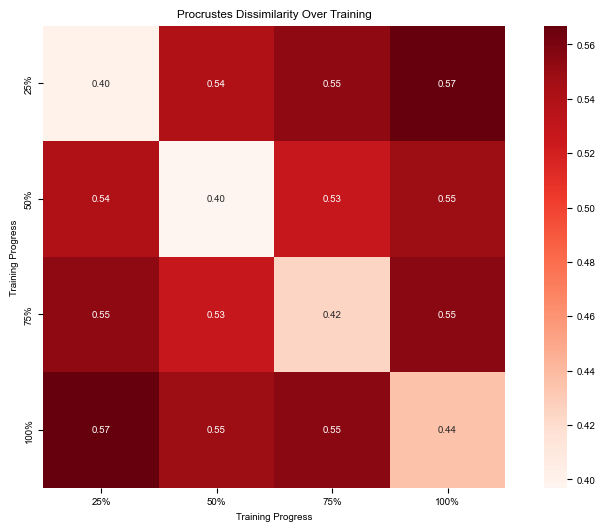

In [27]:
# Percentage labels to use instead of indices
percent_labels = ["25%", "50%", "75%", "100%"]

for measure, value in dissimilarities.items():
    # Create the heatmap
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(value, annot=True, cmap="Reds", cbar=True, square=True, fmt=".2f")

    # Set the percentage labels on the x and y axes
    ax.set_xticklabels(percent_labels)
    ax.set_yticklabels(percent_labels)

    # Set axis labels
    ax.set_xlabel("Training Progress")
    ax.set_ylabel("Training Progress")

    # Set the title
    plt.title(f"{measure.capitalize()} Dissimilarity Over Training")

    # Show the plot
    plt.show()